In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from datetime import datetime
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 70) #view 70 columns

<hr style="border:1px solid gray"> </hr>

## EDA
- Create visualizations to understand dataset
    - understand the distribution of different columns
    - check for multicollinearity
- Check that the dataset meets the assumptions (for regression)
[//]: # "- Check the balance of the different classes (for classification task)"
[//]: # "- Check that the dataset meets the assumptions (for regression task)"

#### Load clean data

In [4]:
df = pd.read_csv('data/clean_data.csv').iloc[:, 1:]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21417 non-null  object 
 1   id             21417 non-null  int64  
 2   price          21417 non-null  float64
 3   bedrooms       21417 non-null  int64  
 4   sqft_living    21417 non-null  int64  
 5   sqft_lot       21417 non-null  int64  
 6   waterfront     21417 non-null  float64
 7   view           21417 non-null  int64  
 8   condition      21417 non-null  int64  
 9   grade          21417 non-null  int64  
 10  zipcode        21417 non-null  int64  
 11  lat            21417 non-null  float64
 12  long           21417 non-null  float64
 13  renovated      21417 non-null  int64  
 14  basement       21417 non-null  int64  
 15  multilevel     21417 non-null  int64  
 16  bedrooms_bin   21417 non-null  object 
 17  bathrooms_bin  21417 non-null  object 
 18  grade_

Objects should be converted back to category except date. Because I'm unlikely to use 'date', I won't switch this back to a datatime object. Likely won't use zipcode or lat/long, at least initally.

In [6]:
df[['bedrooms_bin', 'bathrooms_bin','grade_bin',
    'yr_quarter']] = df[['bedrooms_bin','bathrooms_bin',
                         'grade_bin', 'yr_quarter']].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           21417 non-null  object  
 1   id             21417 non-null  int64   
 2   price          21417 non-null  float64 
 3   bedrooms       21417 non-null  int64   
 4   sqft_living    21417 non-null  int64   
 5   sqft_lot       21417 non-null  int64   
 6   waterfront     21417 non-null  float64 
 7   view           21417 non-null  int64   
 8   condition      21417 non-null  int64   
 9   grade          21417 non-null  int64   
 10  zipcode        21417 non-null  int64   
 11  lat            21417 non-null  float64 
 12  long           21417 non-null  float64 
 13  renovated      21417 non-null  int64   
 14  basement       21417 non-null  int64   
 15  multilevel     21417 non-null  int64   
 16  bedrooms_bin   21417 non-null  category
 17  bathrooms_bin  21417 non-null  

#### Explore target variable (price)
Non-normality in price may hurt correlations with the features so addressing outliers may help, which will hurt assumption checks (like linearity and homoscedasticity) later.

450000.0    172
350000.0    167
550000.0    157
500000.0    151
425000.0    149
325000.0    146
400000.0    144
Name: price, dtype: int64

<AxesSubplot:>

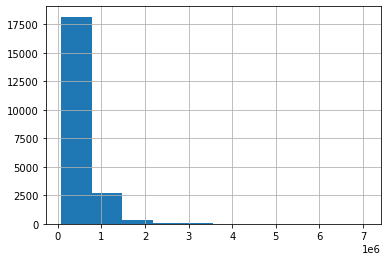

In [7]:
display(df['price'].value_counts().head(7))
df['price'].hist()

<AxesSubplot:xlabel='price'>

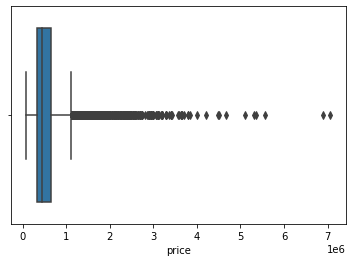

In [8]:
sns.boxplot(x = df['price'])

In [9]:
len(df[(df['price'] > 1.2e6)])

970

In [10]:
df_no_y_outlrs = df[(df['price'] < 1.2e6)]
df_no_y_outlrs['price'].max()

1190000.0

<AxesSubplot:>

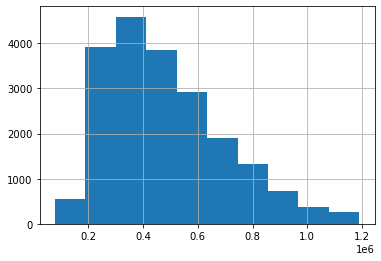

In [11]:
df_no_y_outlrs['price'].hist()

<AxesSubplot:xlabel='price'>

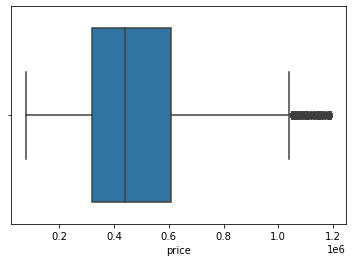

In [12]:
sns.boxplot(x = df_no_y_outlrs['price'])

#### Check heatmap for multicollinearity and strong correlations b/w price and the features

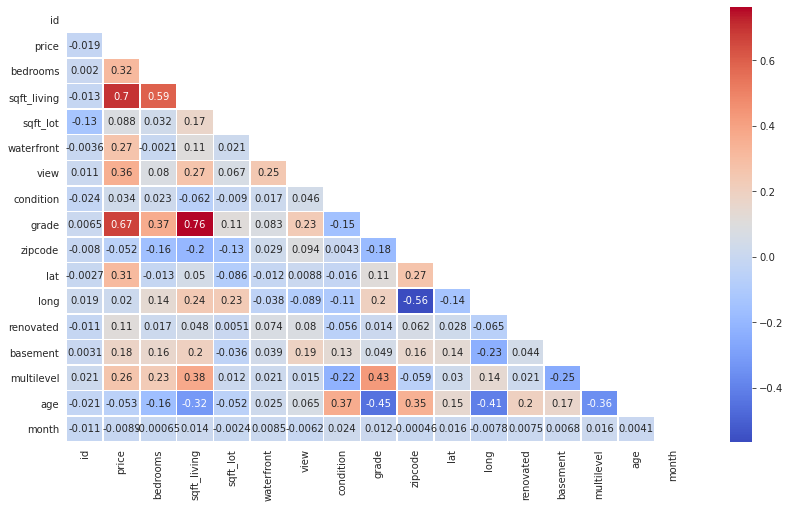

In [13]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 8))
    ax = sns.heatmap(df.corr(), mask=mask, cmap='coolwarm',
                     linewidths=.5, annot=True)

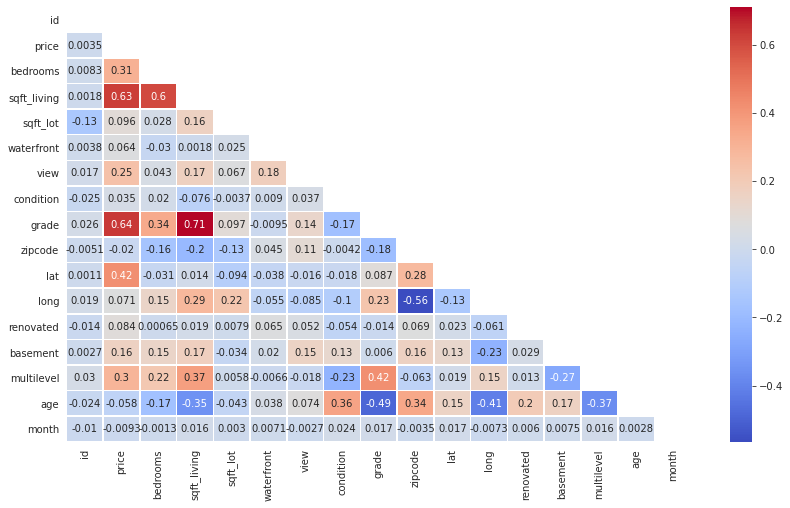

In [14]:
mask = np.zeros_like(df_no_y_outlrs.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 8))
    ax = sns.heatmap(df_no_y_outlrs.corr(), mask=mask, cmap='coolwarm',
                     linewidths=.5, annot=True)

- Price strong correlations:
    - grade, sqft_living
- Price moderate correlations:
    - view, bedrooms, waterfront, multilevel
- Strong multicollinearity:
    - grade and sqft_living, sqft_living and bedrooms
- Moderate multicollinearity:
    - sqft_living and multilevel, age and condition, age and grade
- Other notes (dropping weak feature candidates):   
    - condition looks like a weak candidate for our model because it shows no correlation with price and grade (like we would expect), and we don't know much about the source of this data, so we will drop
    - id, zip, long, lat and date show little to offer for our model so we will drop these. 
    - sqft_lot, age, month, renovated, waterfront look like poor candidates with their weak correlations. 

In [15]:
df_strong_can = df_no_y_outlrs[['price', 'bedrooms', 'sqft_living', 'view',
                                'grade', 'basement', 'bedrooms_bin', 
                                'bathrooms_bin', 'grade_bin', 'yr_quarter']]

Show scatter matrix to see weak and strong candidates

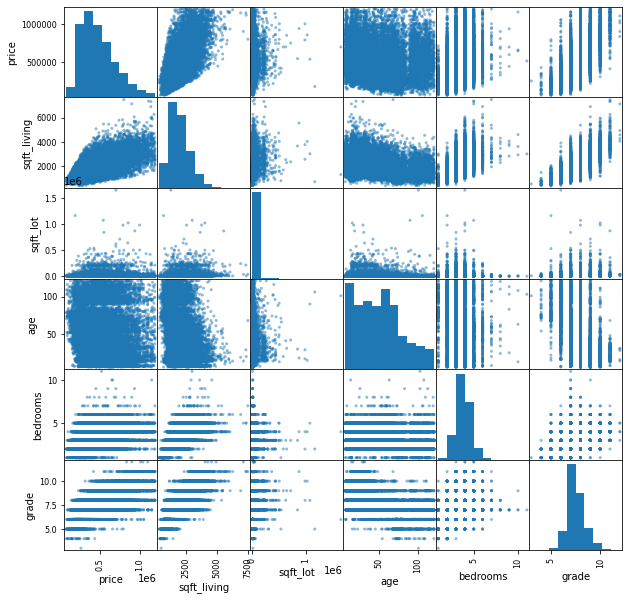

In [16]:
pd.plotting.scatter_matrix(df_no_y_outlrs[['price','sqft_living','sqft_lot',
                           'age','bedrooms','grade']], figsize=(10,10),
                           diagonal='hist'); # diagonal='kde' to view kde

#### Split continuous and categorical variables

In [17]:
def cats_and_conts(df):
    conts = []
    cats = []
    for col in df.columns:
        if df[col].nunique() < 20:
            cats.append(col)
        else:
            conts.append(col)
    return df[cats], df[conts]
df_cats, df_conts = cats_and_conts(df_strong_can)
print('DF with sqft (cats/conts):\n', df_cats.columns, '\n', df_conts.columns)

DF with sqft (cats/conts):
 Index(['bedrooms', 'view', 'grade', 'basement', 'bedrooms_bin',
       'bathrooms_bin', 'grade_bin', 'yr_quarter'],
      dtype='object') 
 Index(['price', 'sqft_living'], dtype='object')


#### Explore categorical variables and our only continuous variable, sqft_living
View scatter matrix and look at scatter plots with 'price' on y-axis. Also see distribution/histograms of variables. While normality for variables is not required, the variable distributions may affect model performance. 

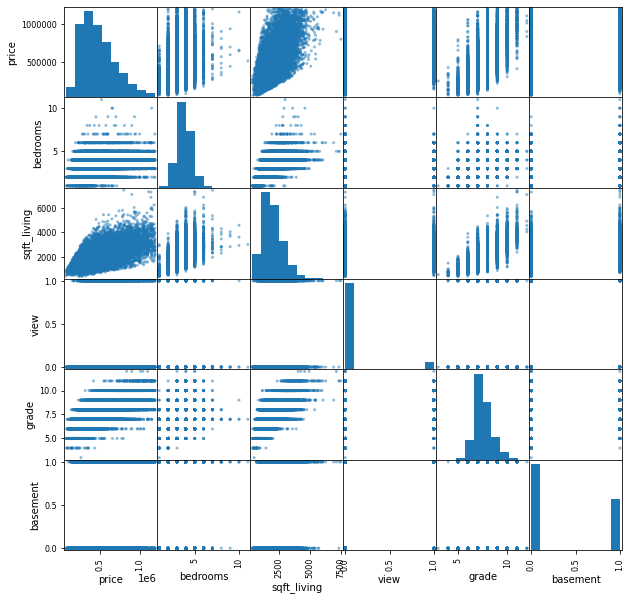

In [18]:
pd.plotting.scatter_matrix(df_strong_can, figsize=(10,10),
                           diagonal='hist'); # diagonal='kde' to view kde

Notes on the graphs above:
- Histograms (of features):
    - again, normality not required but worth keeping an eye on
    - grade looks about normally distributed
    - bedrooms and sqft_living are right skewed
    - transforming/scaling these may help later 
- Scatterplots:
    - show heteroscedasticity, but can be fixed with transformations
- recall sqft_living has multicollinearity with grade and bedrooms

<hr style="border:1px solid gray"> </hr>

## Model 1 (Initial/Baseline)
- Feature Select
- Build and tune the model(s)
- Evaluate if results are promising
- Tune if evaluation shows promise

#### Feature Select

In [19]:
df_strong_can.columns

Index(['price', 'bedrooms', 'sqft_living', 'view', 'grade', 'basement',
       'bedrooms_bin', 'bathrooms_bin', 'grade_bin', 'yr_quarter'],
      dtype='object')

#### M1 categorical variables: one hot encode
- Leaving out grades and bedrooms since we binned these categorical variables

In [20]:
df_m1_cats = df_strong_can[['view', 'basement', 'bedrooms_bin',
                'bathrooms_bin', 'grade_bin', 'yr_quarter']].astype('category')
df_m1_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20407 entries, 0 to 21416
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   view           20407 non-null  category
 1   basement       20407 non-null  category
 2   bedrooms_bin   20407 non-null  category
 3   bathrooms_bin  20407 non-null  category
 4   grade_bin      20407 non-null  category
 5   yr_quarter     20407 non-null  category
dtypes: category(6)
memory usage: 279.9 KB


In [21]:
df_m1_cats = pd.get_dummies(df_m1_cats, drop_first = True)
df_m1_cats.head()

,view_1,basement_1,bedrooms_bin_3,bedrooms_bin_4,bedrooms_bin_5_more,bathrooms_bin_2-2.5,bathrooms_bin_2.75_more,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_2,yr_quarter_3,yr_quarter_4
0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,1,0,0,0,0


#### Model 1 continuous variables
- Don't transform for this initial model

In [22]:
df_m1_conts = df_strong_can[['price', 'sqft_living']]
df_m1_conts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20407 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        20407 non-null  float64
 1   sqft_living  20407 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 478.3 KB


In [23]:
df_m1 = pd.concat([df_m1_cats, df_m1_conts], axis = 1)
display(df_m1.head())

,view_1,basement_1,bedrooms_bin_3,bedrooms_bin_4,bedrooms_bin_5_more,bathrooms_bin_2-2.5,bathrooms_bin_2.75_more,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_2,yr_quarter_3,yr_quarter_4,price,sqft_living
0,0,0,1,0,0,0,0,0,0,0,0,0,1,221900.0,1180
1,0,1,1,0,0,1,0,0,0,0,0,0,1,538000.0,2570
2,0,0,0,0,0,0,0,1,0,0,0,0,0,180000.0,770
3,0,1,0,1,0,0,1,0,0,0,0,0,1,604000.0,1960
4,0,0,1,0,0,1,0,0,1,0,0,0,0,510000.0,1680


Rename the columns for the formula, so they don't contain numbers.

In [24]:
df_m1.columns

Index(['view_1', 'basement_1', 'bedrooms_bin_3', 'bedrooms_bin_4',
       'bedrooms_bin_5_more', 'bathrooms_bin_2-2.5', 'bathrooms_bin_2.75_more',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_2', 'yr_quarter_3', 'yr_quarter_4', 'price', 'sqft_living'],
      dtype='object')

In [25]:
df_m1.columns = ['view', 'basement', 'bedrooms_three', 'bedrooms_bin_4',
       'bedrooms_five_more', 'bathrooms_two_two_pt_five', 'bathrooms_two_pt_seven_five_more',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_two', 'yr_quarter_three', 'yr_quarter_four', 'price', 'sqft_living']

In [26]:
df_X1_cols = ['view', 'basement', 'bedrooms_three', 'bedrooms_bin_4',
       'bedrooms_five_more', 'bathrooms_two_two_pt_five', 'bathrooms_two_pt_seven_five_more',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_two', 'yr_quarter_three', 'yr_quarter_four', 'sqft_living']

In [27]:
df_y = df_m1['price']
df_X1 = df_m1[df_X1_cols]
df_X1.head(2)

,view,basement,bedrooms_three,bedrooms_bin_4,bedrooms_five_more,bathrooms_two_two_pt_five,bathrooms_two_pt_seven_five_more,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_two,yr_quarter_three,yr_quarter_four,sqft_living
0,0,0,1,0,0,0,0,0,0,0,0,0,1,1180
1,0,1,1,0,0,1,0,0,0,0,0,0,1,2570


#### Fit the model

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [29]:
X1 = '+'.join(list(df_X1.columns))
y = list(df_y.to_frame().columns)[0]
f = str(y) + '~' + X1

model1 = ols(formula= f, data=df_m1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1470.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:52:43   Log-Likelihood:            -2.7233e+05
No. Observations:               20407   AIC:                         5.447e+05
Df Residuals:                   20392   BIC:                         5.448e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         2.591e+05   4806.898     53.908      0.000     2.5e+05    2.69e+05
view                                8.9e+04   4044.460     22.007      0.000    8.11e+04    9.69e+04
basement                           3.96e+04   2327.176     17.014      0.000     3.5e+04    4.42e+04
bedrooms_three                   -4.029e+04   3478.571    -11.583      0.000   -4.71e+04   -3.35e+04
bedrooms_bin_4                   -4.174e+04   4126.242    -10.115      0.000   -4.98e+04   -3.36e+04
bedrooms_five_more               -4.745e+04   5668.107     -8.371      0.000   -5.86e+04   -3.63e+04
bathrooms_two_two_pt_five        -2.716e+04   2774.523     -9.790      0.000   -3.26e+04   -2.17e+04
bathrooms_two_pt_seven_five_more  5494.2461   4151.922      1.323      0.186   -2643.854    1.36e+04
grade_bin_below_average          -6.633e+04   3834.317    -17.299      0.000   -7.38e+04   -5.88e+04
grade_bin_good                    8.191e+04   2794.845     29.309      0.000    7.64e+04    8.74e+04
grade_bin_great                   2.126e+05   4190.920     50.720      0.000    2.04e+05    2.21e+05
yr_quarter_two                    1.271e+04   3071.106      4.140      0.000    6695.309    1.87e+04
yr_quarter_three                   610.3772   3157.929      0.193      0.847   -5579.417    6800.172
yr_quarter_four                  -7335.5232   3311.858     -2.215      0.027   -1.38e+04    -844.015
sqft_living                         98.0122      2.432     40.306      0.000      93.246     102.779
==============================================================================
Omnibus:                     1236.838   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1632.456
Skew:                           0.566   Prob(JB):                         0.00
Kurtosis:                       3.800   Cond. No.                     1.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Checking for multicollinearity
- Check VIF scores

In [50]:
vif_scores = [variance_inflation_factor(df_X1.values, i) for i in range(df_X1.shape[1])]
list(zip(df_X1_cols, vif_scores))

[('view', 1.1555035273726801),
 ('basement', 1.7994440413426143),
 ('bedrooms_three', 4.202567662213989),
 ('bedrooms_bin_4', 4.515927746263287),
 ('bedrooms_five_more', 2.2656892405649685),
 ('bathrooms_two_two_pt_five', 3.0489772567595934),
 ('bathrooms_two_pt_seven_five_more', 2.2730900189567964),
 ('grade_bin_below_average', 1.1947850219105882),
 ('grade_bin_good', 2.0305107043962294),
 ('grade_bin_great', 2.4036937032030763),
 ('yr_quarter_two', 2.2350030642444723),
 ('yr_quarter_three', 2.0943341825998316),
 ('yr_quarter_four', 1.857261823850715),
 ('sqft_living', 16.803195527860886)]

#### Checking for normality
- Scatter matrix
- Joint plot

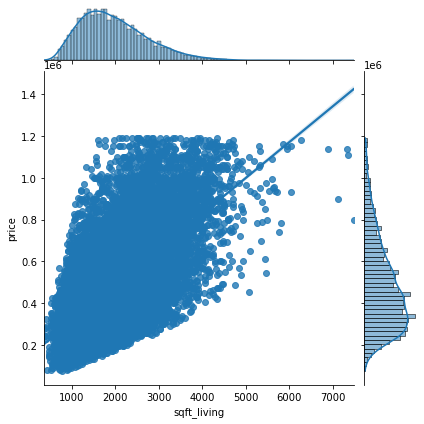

In [32]:
sns.jointplot(x= df_m1['sqft_living'], y= df_m1['price'], data= df_m1, kind='reg')

#### Checking for normality
- QQ-Plot
- JB Test

In [51]:
fig = sm.graphics.qqplot(model1.resid, dist=stats.norm, line='45', fit=True)

NameError: name 'model1' is not defined

#### Checking for homoscedasticity
- scatterplot
- GQ Test

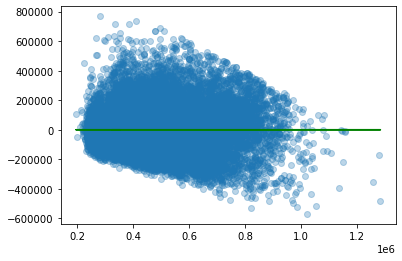

In [34]:
plt.scatter(model1.predict(df_X1), model.resid, alpha = .3)
plt.plot(model1.predict(df_X1), [0 for i in range(len(df_X1))], c='g')


<hr style="border:1px solid gray"> </hr>

## Model 2

#### Feature Select
- Dropping sqft_living because of multicollinearity
- dropping bathrooms_two_pt_seven_five_more and yr_quarter_three because of the high p-values

In [35]:
df_strong_can.columns

Index(['price', 'bedrooms', 'sqft_living', 'view', 'grade', 'basement',
       'bedrooms_bin', 'bathrooms_bin', 'grade_bin', 'yr_quarter'],
      dtype='object')

#### M2 categorical variables: one hot encode
- Leaving out grades and bedrooms since we binned these categorical variables

In [36]:
df_m2_cats = df_strong_can[['view', 'basement', 'bedrooms_bin',
                'bathrooms_bin', 'grade_bin', 'yr_quarter']].astype('category')
df_m2_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20407 entries, 0 to 21416
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   view           20407 non-null  category
 1   basement       20407 non-null  category
 2   bedrooms_bin   20407 non-null  category
 3   bathrooms_bin  20407 non-null  category
 4   grade_bin      20407 non-null  category
 5   yr_quarter     20407 non-null  category
dtypes: category(6)
memory usage: 279.9 KB


In [37]:
df_m2_cats = pd.get_dummies(df_m1_cats, drop_first = True)
df_m2_cats.head()

,view_1,basement_1,bedrooms_bin_3,bedrooms_bin_4,bedrooms_bin_5_more,bathrooms_bin_2-2.5,bathrooms_bin_2.75_more,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_2,yr_quarter_3,yr_quarter_4
0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,1,0,0,0,0


#### Model 2 continuous variables

In [38]:
df_m2 = pd.concat([df_m1_cats, df_strong_can[['price']]], axis = 1)
display(df_m1.head())

,view,basement,bedrooms_three,bedrooms_bin_4,bedrooms_five_more,bathrooms_two_two_pt_five,bathrooms_two_pt_seven_five_more,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_two,yr_quarter_three,yr_quarter_four,price,sqft_living
0,0,0,1,0,0,0,0,0,0,0,0,0,1,221900.0,1180
1,0,1,1,0,0,1,0,0,0,0,0,0,1,538000.0,2570
2,0,0,0,0,0,0,0,1,0,0,0,0,0,180000.0,770
3,0,1,0,1,0,0,1,0,0,0,0,0,1,604000.0,1960
4,0,0,1,0,0,1,0,0,1,0,0,0,0,510000.0,1680


Rename the columns for the formula, so they don't contain numbers.

In [39]:
df_m2.columns

Index(['view_1', 'basement_1', 'bedrooms_bin_3', 'bedrooms_bin_4',
       'bedrooms_bin_5_more', 'bathrooms_bin_2-2.5', 'bathrooms_bin_2.75_more',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_2', 'yr_quarter_3', 'yr_quarter_4', 'price'],
      dtype='object')

In [40]:
df_m2.columns = ['view', 'basement', 'bedrooms_three', 'bedrooms_bin_4',
       'bedrooms_five_more', 'bathrooms_two_two_pt_five', 'bathrooms_two_pt_seven_five_more',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_two', 'yr_quarter_three', 'yr_quarter_four', 'price']

In [41]:
df_X2_cols = ['view', 'basement', 'bedrooms_three', 'bedrooms_bin_4',
       'bedrooms_five_more', 'bathrooms_two_two_pt_five',
       'grade_bin_below_average', 'grade_bin_good', 'grade_bin_great',
       'yr_quarter_two', 'yr_quarter_four']

In [42]:
df_y = df_m2['price']
df_X2 = df_m2[df_X2_cols]
df_X2.head(2)

,view,basement,bedrooms_three,bedrooms_bin_4,bedrooms_five_more,bathrooms_two_two_pt_five,grade_bin_below_average,grade_bin_good,grade_bin_great,yr_quarter_two,yr_quarter_four
0,0,0,1,0,0,0,0,0,0,0,1
1,0,1,1,0,0,1,0,0,0,0,1


#### Fit the model

In [52]:
X2 = '+'.join(list(df_X2.columns))
y = list(df_y.to_frame().columns)[0]
f = str(y) + '~' + X2

model2 = ols(formula= f, data=df_m2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1563.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:56:30   Log-Likelihood:            -2.7321e+05
No. Observations:               20407   AIC:                         5.464e+05
Df Residuals:                   20395   BIC:                         5.465e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3.704e+05   3712.621     99.776      0.000    3.63e+05    3.78e+05
view                       1.057e+05   4201.994     25.149      0.000    9.74e+04    1.14e+05
basement                   5.949e+04   2378.932     25.008      0.000    5.48e+04    6.42e+04
bedrooms_three            -6128.1569   3533.465     -1.734      0.083   -1.31e+04     797.718
bedrooms_bin_4             3.456e+04   3877.885      8.913      0.000     2.7e+04    4.22e+04
bedrooms_five_more         6.843e+04   5147.491     13.295      0.000    5.83e+04    7.85e+04
bathrooms_two_two_pt_five -2.455e+04   2405.623    -10.207      0.000   -2.93e+04   -1.98e+04
grade_bin_below_average   -9.276e+04   3947.540    -23.497      0.000      -1e+05    -8.5e+04
grade_bin_good             1.198e+05   2735.848     43.787      0.000    1.14e+05    1.25e+05
grade_bin_great            3.237e+05   3404.220     95.092      0.000    3.17e+05     3.3e+05
yr_quarter_two             1.138e+04   2550.009      4.461      0.000    6378.064    1.64e+04
yr_quarter_four           -7529.2257   2860.481     -2.632      0.008   -1.31e+04   -1922.454
==============================================================================
Omnibus:                     1250.118   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1626.929
Skew:                           0.577   Prob(JB):                         0.00
Kurtosis:                       3.764   Cond. No.                         9.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Checking for multicollinearity
- Check VIF scores

In [53]:
vif_scores2 = [variance_inflation_factor(df_X2.values, i) for i in range(df_X2.shape[1])]
list(zip(df_X2_cols, vif_scores2))

[('view', 0.055870334596161426),
 ('basement', 0.04178171556962694),
 ('bedrooms_three', 0.015420560284109699),
 ('bedrooms_bin_4', 0.06949995995311514),
 ('bedrooms_five_more', 0.06989706189189795),
 ('bathrooms_two_two_pt_five', 0.021026893873369985),
 ('grade_bin_below_average', 0.10243794298988776),
 ('grade_bin_good', 0.016507086300326088),
 ('grade_bin_great', 0.11651925859532551),
 ('yr_quarter_two', 0.007927553207946532),
 ('yr_quarter_four', 0.04157967663772034)]

#### Checking for linearity
- Scatter matrix
- Joint plot

In [48]:
# sns.jointplot(x= df_m1['view'], y= df_m1['price'], data= df_m1, kind='reg')

#### Checking for normality
- QQ-Plot
- JB Test

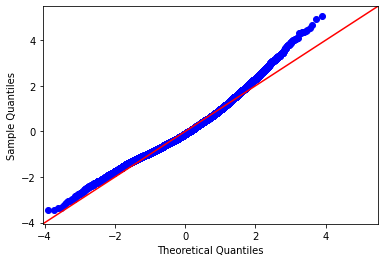

In [54]:
fig = sm.graphics.qqplot(model2.resid, dist=stats.norm, line='45', fit=True)

#### Checking for homoscedasticity
- scatterplot
- GQ Test

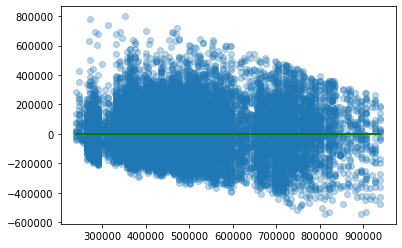

In [58]:
plt.scatter(model2.predict(df_X2), model2.resid, alpha = .3)
plt.plot(model2.predict(df_X2), [0 for i in range(len(df_X2))], c='g')


<hr style="border:1px solid gray"> </hr>

## Model 3

<hr style="border:1px solid gray"> </hr>

## Interpret Results
- Interpret results of the model(s)
- Communicate results to the stakeholders
- Identify next steps

#### Conclusion

#### Next Steps

#### Notes and extra code
In the log-log- model, see that

𝛽1=∂log(𝑦)∂log(𝑥).

Recall that

∂log(𝑦)∂𝑦=1𝑦

or

∂log(𝑦)=∂𝑦𝑦.

Multiplying this latter formulation by 100 gives the percent change in 𝑦. We have analogous results for 𝑥.

Using this fact, we can interpret 𝛽1 as the percent change in 𝑦 for a 1 percent change in 𝑥.

Following the same logic, for the level-log model, we have

𝛽1=∂𝑦∂log(𝑥)=100∂𝑦100×∂log(𝑥).

or 𝛽1/100 is the unit change in 𝑦 for a one percent change in 𝑥.

In [ ]:
plt.figure(figsize = (10,10))
sns.scatterplot(x='long',y='lat',hue='price',data=df)
plt.title('Lat vs Long, Price with Color')

In [ ]:
df['sector_1'] = df.iloc[(df.lat > 122) & (df.long < )]
df['sector_2'] = df.iloc[(df.lat > 122) & (df.long < )]
df['sector_3'] = df.iloc[(df.lat > 122) & (df.long < )]
df['sector_4'] = df.iloc[(df.lat > 122) & (df.long < )]
df['sector_5'] = df.iloc[(df.lat > 122) & (df.long < )]
df['sector_6'] = df.iloc[(df.lat > 122) & (df.long < )]

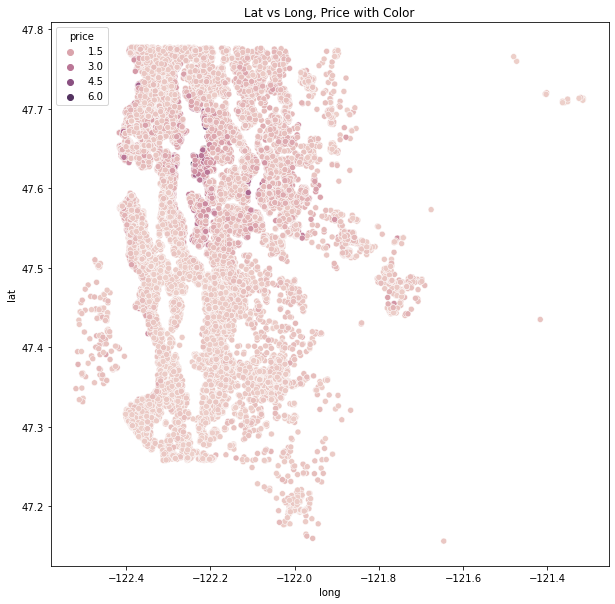

In [5]:
plt.figure(figsize = (10,10))
sns.scatterplot(x='long',y='lat',hue='price',data=df_sqft)
plt.title('Lat vs Long, Price with Color');

#### Student

In [ ]:
zipcodes = pd.get_dummies(df['zipcode'], prefix = 'zipcode')
zipcodes

In [ ]:
df_with_zip = pd.concat([df, zipcodes], axis = 1)

In [ ]:
df_with_zip.info()

In [ ]:
df.loc[(df.lat > 47.5) & (df.long > -122.2), "sector_1"] = 1
df.info()

In [ ]:
plt.figure(figsize=(12,9))
sns.scatterplot(x = "long", y = "lat", hue = "sector_1" , data=df)

#### Folium

In [11]:
df.lat.min()

In [ ]:
# !pip install folium

In [ ]:
import folium


In [ ]:
kc_coordinates = (47.54, -121.98)


In [ ]:
kc_map = folium.Map(location = kc_coordinates)


In [ ]:
kc_map


In [ ]:
# manipulate df
df.groupby(['zipcode']).median()[['lat', 'long', 'price']].values.tolist()

In [ ]:
from folium.plugins import HeatMap

In [ ]:
HeatMap(data = df.groupby(['zipcode']).median()[['lat', 'long', 'price']].values.tolist()).add_to(kc_map)


In [ ]:
display(kc_map)


#### Plotly

In [ ]:
# !pip install plotly


In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(df, x = "bedrooms", y = "price")
fig.show()

In [ ]:
px.box(df, x = "grade", y = "price")

In [ ]:
px.scatter(df, x = "sqft_living", y = "price", trendline= "ols")